In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyStochastic = MdpKernel()
mdpPolicyStochastic.load_policy(mdpKernelParams, policyMode="stochastic")
mdpPolicyDeterministic = MdpKernel()
mdpPolicyDeterministic.load_policy(mdpKernelParams, policyMode="deterministic")

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyDeterministic, env)
simResultDeterministic = policySimulator.runSimulation(mdpPolicyDeterministic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")

(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)

'''
policySimulator = PolicySimulator(mdpPolicyStochastic, env)
simResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultStochastic['uRecord'], simResultDeterministic['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultStochastic['uRecord'] + simResultDeterministic['uRecord'], 
    simResultStochastic['actionsRecord'] + simResultDeterministic['actionsRecord'], 
    simResultStochastic['rewardRecord'] + simResultDeterministic['rewardRecord'], 
    simResultStochastic['uNextRecord'] + simResultDeterministic['uNextRecord']
)
'''

Simulation Progress: 100%|██████████| 5000/5000 [00:08<00:00, 557.17it/s, avg reward=0.003798]


'\npolicySimulator = PolicySimulator(mdpPolicyStochastic, env)\nsimResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")\nuRecord = np.concatenate((simResultStochastic[\'uRecord\'], simResultDeterministic[\'uRecord\']))\n(uRecord, actionsRecord, rewardRecord, uNextRecord) = (\n    simResultStochastic[\'uRecord\'] + simResultDeterministic[\'uRecord\'], \n    simResultStochastic[\'actionsRecord\'] + simResultDeterministic[\'actionsRecord\'], \n    simResultStochastic[\'rewardRecord\'] + simResultDeterministic[\'rewardRecord\'], \n    simResultStochastic[\'uNextRecord\'] + simResultDeterministic[\'uNextRecord\']\n)\n'

In [4]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 5e-3,
    'eta': 0.05,
    'n_candidates': 20
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env,
    clonePolicy=True,
    epochs=100, 
    batch_size=512,
    updateCriticOnly=False)

Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 102.65it/s]                                    


Epoch   10/ 100  Avg Ld=0.455337  Avg Lq=-0.879765  Avg loss_critic=0.092485  Test packet loss=0.0066


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 106.53it/s]                                    


Epoch   20/ 100  Avg Ld=0.091136  Avg Lq=-1.135526  Avg loss_critic=0.012821  Test packet loss=0.0052


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 105.10it/s]                                    


Epoch   30/ 100  Avg Ld=0.066728  Avg Lq=-1.412170  Avg loss_critic=0.028805  Test packet loss=0.0052


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 105.95it/s]                                    


Epoch   40/ 100  Avg Ld=0.054383  Avg Lq=-1.862765  Avg loss_critic=0.027502  Test packet loss=0.0055


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 104.74it/s]                                    


Epoch   50/ 100  Avg Ld=0.045147  Avg Lq=-2.437344  Avg loss_critic=0.012059  Test packet loss=0.0056


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 102.84it/s]                                    


Epoch   60/ 100  Avg Ld=0.041191  Avg Lq=-2.885011  Avg loss_critic=0.003719  Test packet loss=0.0044


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 106.44it/s]                                    


Epoch   70/ 100  Avg Ld=0.038423  Avg Lq=-3.361919  Avg loss_critic=0.002311  Test packet loss=0.0055


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 104.68it/s]                                    


Epoch   80/ 100  Avg Ld=0.034989  Avg Lq=-3.863808  Avg loss_critic=0.002925  Test packet loss=0.0055


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 105.17it/s]                                    


Epoch   90/ 100  Avg Ld=0.030932  Avg Lq=-4.332428  Avg loss_critic=0.004673  Test packet loss=0.0049


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 105.59it/s]                                     

Epoch  100/ 100  Avg Ld=0.032965  Avg Lq=-4.784387  Avg loss_critic=0.007734  Test packet loss=0.0037


In [5]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl


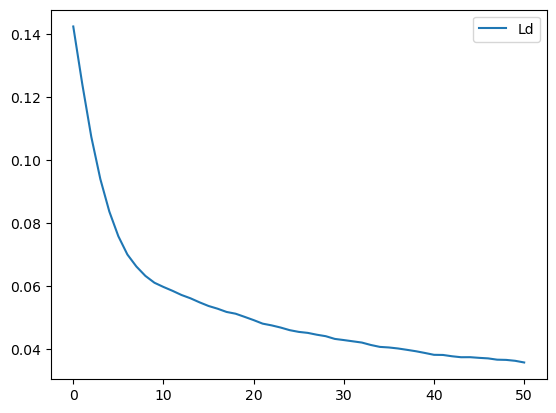

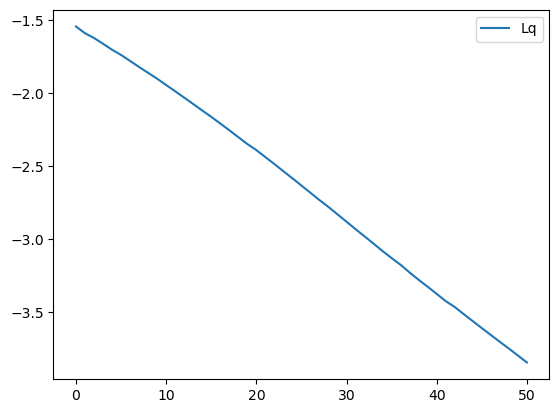

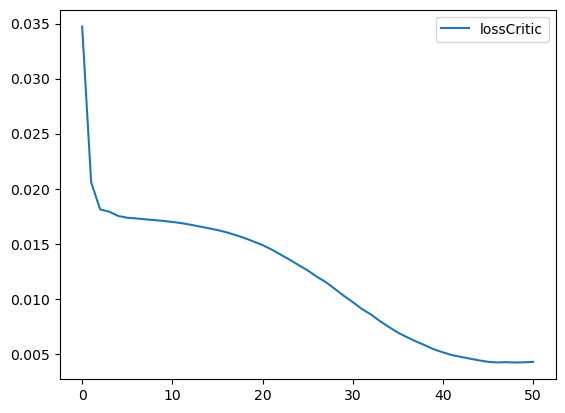

In [6]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 50
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()